# Building Instustrial Deep Learning Solutions

<p style="text-align: center;">Daniele Solombrino <br>
dansolombrino@{gmail.com,GitHub}</p>

## Virtual Environments

First rule of a good coding project: hygiene!

Every project should have its own **Python virtual environment**, so as packages installed for one project do not collide with packages needed by other projects.

Python virtual environments can be created in different ways.

Today, we will use `python venv`, which comes already installed in the latest Python versions (>=3.3)

First, we are going to create the virtual environment, by pasting the following code into the terminal

`python -m venv digits_classification`

Then, we are going to activate the virtual environment by pasting this other line into the terminal

`source digits_classification/bin/activate`

## requirements.txt

Each project requires some Python packages to be installed.

Add them all in the file named `requirements.txt`.

Anytime someone has to replicate your environment, they will simply do a `pip3 install -r requirements.txt` on their machine, after having created and activated the virtual environment.

## The problem

You are handling a client which gave you a problem to solve.

This problem includes the following need: recognize handwritten digits that have been OCR'd from a system the client is already using.

## Data

### Data loading

After some time spent online, you find information about this dataset, which is the closest to the inputs that the client has: [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

You start looking around and you find different sources to get it, including [this](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) Kaggle page and [this](https://github.com/yawen-d/Neural-Network-on-MNIST-with-NumPy-from-Scratch) GitHub repo.

You look at the pages and you find that the GitHub has the files in a much much more convenient way, so you decide to download them from there.

For practicality, the data has been already downloaded for you and are included in this repo.

Remember what we have stated in the previous weeks: never, EVER, trust code coming from other people blindly.

For this reason, we are going to look into the data.

The file is in hdf5 format, which needs its Python lib to be handled correctly.

We add the library to the `requirements.txt` file and install it by doing `pip3 install h5py`

In [19]:
import h5py

In [20]:
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')

Since we have zero trust on whoever provided the data, first and foremost, we are going to see that data is stored inside the archive file.

h5 files can be treated as dictionaries, so the first thing that makes sense is to look at the keys of the archive.

In [21]:
from rich import print # nicer prints

In [22]:
print(MNIST_data.keys())

<KeysViewHDF5 ['x_test', 'x_train', 'y_test', 'y_train']>

### Data splitting

The archive has four Tensors: X_train, X_test, Y_train, Y_test.

A couple of questions for you:

1) Why $X$ and $Y$?
2) Why train and test?

$X$ are the inputs and $Y$ are the outputs, as we are in a supervised setting scenario!

As we stated these weeks, we want Machine/Deep Learning models that generalize to never-seen-before data! <br>
For this reason, we hold a portion of the data out, the test data, to verify our performance on data never seen before!<br>
To be complete, we are also going to get another portion of data not used for training, the "validation" set.<br>
We are going to give more details about test vs. validation it in the appropriate time, for now, we are just going to save the various data splits.

In [23]:
# train data
X_train = MNIST_data['x_train'][:]
Y_train = MNIST_data['y_train'][:]

# test data
X_test = MNIST_data['x_test'][:]
Y_test = MNIST_data['y_test'][:]

In [24]:
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_train.shape: (60000, 784)

Y_train.shape: (60000, 1)

X_test.shape: (10000, 784)

Y_test.shape: (10000, 1)

Do these shapes make sense to you? What do you think these values mean?

$60k$ and $10k$ are the number of data samples in each split.

$768$ is the number of features that each data sample has.

$1$ is the label for each sample

Let's create the additional validation split

In [25]:
X_val = X_train[50000:60000]
Y_val = Y_train[50000:60000]

X_train = X_train[0:50000]
Y_train = Y_train[0:50000]

In [26]:
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"Y_val.shape: {Y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_train.shape: (50000, 784)

Y_train.shape: (50000, 1)

X_val.shape: (10000, 784)

Y_val.shape: (10000, 1)

X_test.shape: (10000, 784)

Y_test.shape: (10000, 1)

There is not a fixed rule about the split sizes. The most used values are: 60/20/20, 70/20/10 and 80/10/10 (train %/val %/test %).

In this case, we are using a 70/15/15, as other percentages would've required more operations to be computed.

Hygiene rule: never, EVER, have overlapping data samples between the splits. 

Training data is for training.
Validation data is for validation.
Test data is for testing.

Each split has its own "goal".

### Providing data to models

We have some data in memory, but we still need to have a way of bringing this data to the model that we will use for our predictions.

The framework we are going to use, PyTorch, provides an abstract class, `Dataset`, which we are supposed to specialize.

The abstract class `Dataset` requires the specification of two methods, `init()`, `len()`, and `get_item()`.

The `init()` method simply builds the specialized `Dataset` object, the `len()` method returns the total number of elements in the dataset, while the `get_item()` method is responsible for actually providing data when necessary. 

In [27]:
import torch
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, X_data, Y_data):
        """
        Initializes the dataset with features and labels.

        Args:
            X_data (numpy array): The feature data, e.g., images.
            Y_data (numpy array): The labels corresponding to the images.
        """
        self.X_data = X_data  # Store the features
        self.Y_data = Y_data  # Store the labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.X_data)

    def __getitem__(self, idx):
        """
        Generates one sample of data.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label) where image is the input data and label is the corresponding label.
        """
        # Retrieve the image and label using the index
        image = self.X_data[idx]
        label = self.Y_data[idx]

        # Convert the image and label to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return {
            "image": image, 
            "label": label
        }

Let's now instantiate three `MNISTDataset` objects, one for each split

In [28]:
ds_train = MNISTDataset(X_data=X_train, Y_data=Y_train)
ds_val = MNISTDataset(X_data=X_val, Y_data=Y_val)
ds_test = MNISTDataset(X_data=X_test, Y_data=Y_test)

Let's now try whether they work as expected or not...

In [29]:
print(f"len(ds_train): {len(ds_train)}")
print(f"len(ds_val): {len(ds_val)}")
print(f"len(ds_test): {len(ds_test)}")

len(ds_train): 50000

len(ds_val): 10000

len(ds_test): 10000

In [31]:
image, label = ds_train[0].values()

print(f"image.shape: {image.shape}")
print(f"label.shape: {label.shape}")
print(f"image: {image}")
print(f"label: {label}")

image.shape: torch.Size([784])

label.shape: torch.Size([1])

image: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
        0.0706, 0.0706, 0.0706, 0.4941, 0.5333, 0.6863, 0.1020, 0.6510, 1.0000,
        0.9686, 0.4980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176, 0.1412, 0.3686, 0.6039,
        0.6667, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.8824, 0.6745, 0.9922,
        0.9490, 0.7647, 0.2510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922, 0.9333, 0.9922, 0.9922,
        0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9843, 0.3647, 0.3216,
        0.3216, 0.2196, 0.1529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.8588, 0.9922,
        0.9922, 0.9922, 0.9922, 0.9922, 0.7765, 0.7137, 0.9686, 0.9451, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3137,
        0.6118, 0.4196, 0.9922, 0.9922, 0.8039, 0.0431, 0.0000, 0.1686, 0.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0549, 0.0039, 0.6039, 0.9922, 0.3529, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5451, 0.9922, 0.7451, 0.0078, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.7451, 0.9922, 0.2745,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1373, 0.9451,
        0.8824, 0.6275, 0.4235, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3176, 0.9412, 0.9922, 0.9922, 0.4667, 0.0980, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1765, 0.7294, 0.9922, 0.9922, 0.5882, 0.1059, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

label: tensor([5])

Let's do some sanity checks...

Iterate through the entire dataset

In [32]:
for x in ds_train:
    image, label = x.values()
    pass

for x in ds_val:
    image, label = x.values()
    pass

for x in ds_test:
    image, label = x.values()
    pass

And let's look at some samples...

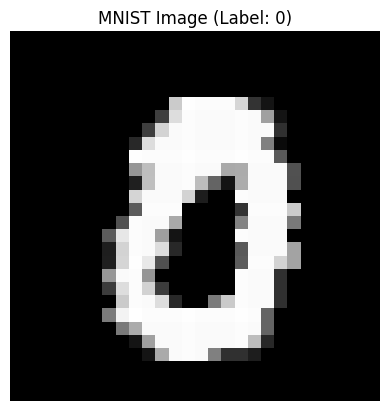

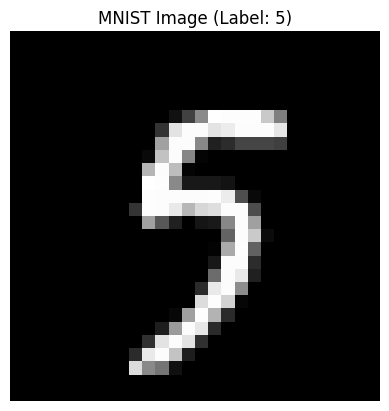

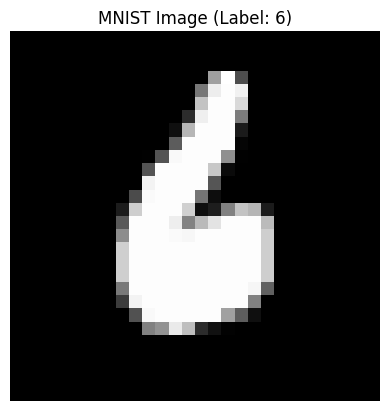

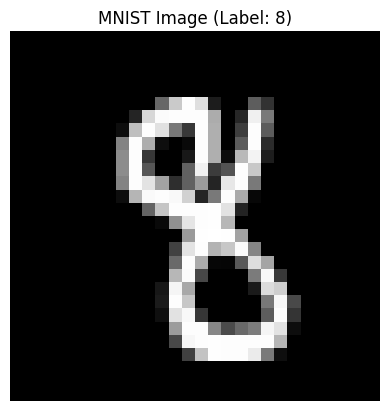

In [38]:
import torch
import matplotlib.pyplot as plt

for idx in [69, 420, 1337, -1]:
    image, label = ds_train[idx].values()

    # Reshape the image tensor to a 28x28 matrix
    image = image.view(28, 28)

    # Plot the image using matplotlib
    # The image is in grayscale, so we use the 'gray' colormap
    plt.imshow(image.numpy(), cmap='gray')
    # Add a title with the label of the image
    plt.title(f'MNIST Image (Label: {label.item()})')
    # Hide the axes for better visualization
    plt.axis('off')
    # Display the plot
    plt.show()

Notice that we had to reshape data.

The dataset has flattened the 2D images into 1D vectors, but plotting them requires them to be in their natural shape.

Familiarize with the concept of reshaping, as it will be crucial for Deep Learning practitioners!

The `MNISTDataset` class is the first data-related component that we need.

The second one is a `DataLoader` instance.

The DataLoader is the object actually responsible for loading data from the disk and getting it ready for the model to use.

The DataLoader also solves a very important need in Deep Learning: data batching.

When we talked about Gradient Descent, we skipped an important detail: how many data samples are needed to perform a parameter update?

Classic Gradient Descent requires all data to be taken into consideration, but it is impossible due to memory constraints.

For these reasons, Stochastic Gradient Descent (SGD) is the most used version of GD, where the update is performed after having seen just a bunch (a batch, or mini-batch!) of data!

Getting a DataLoader is as simple as instantiating its PyTorch object.

The main parameters to pass to a DataLoader are:
- the dataset itself
- the batch size, i.e. the number of elements that are required to perform the parameter update
- whether to shuffle the data or not

Shuffling the data is extremely important during training and it can be avoided at validation and test time.

Why?

Remember: Deep Learning models will try to cheat as much as possible, and one possible cheating may be the memorization of the data position in the dataset (e.g. the second element is always an 8? The model will memorize this and not look at the actual contents of the data)


In [41]:
from torch.utils.data import DataLoader

train_loader = DataLoader(ds_train, batch_size=8, shuffle=True)

val_loader = DataLoader(ds_val, batch_size=8, shuffle=False)

test_loader = DataLoader(ds_test, batch_size=8, shuffle=False)